# Restore the kinetics model from observed trajectory
To run this notebook dependencies from [requirement-dev.txt](../requirements-dev.txt) and `ipywidgets` have to be installed.

Outline:
- Define Enzyme Kinetics model using `kinetics` package
- Generate concentration trajectories
- Define differentiable Enzyme Kinetics model with incorrect parameters
- Restore correct parameters from the observed trajectory with gradient optimization

In [26]:
import kinetics
import numpy as np
import torch
import torchdiffeq
import tqdm.notebook as tqdm

from torch_kinetics import reactions, models, plotting

## Generate trajectory data using Kinetics

In [2]:
# define reactions
enzyme_1 = kinetics.Uni(
    kcat="enz1_kcat",
    kma="enz1_km",
    enz="enz_1",
    a="A",
    substrates=["A"],
    products=["B"],
)
enzyme_1.parameters = {"enz1_kcat": 100, "enz1_km": 8000}

enzyme_2 = kinetics.Uni(
    kcat="enz2_kcat",
    kma="enz2_km",
    enz="enz_2",
    a="B",
    substrates=["B"],
    products=["C"],
)
enzyme_2.parameters = {"enz2_kcat": 30, "enz2_km": 2000}

In [3]:
# set up the model
kinetics_model = kinetics.Model(logging=False)
kinetics_model.append(enzyme_1)
kinetics_model.append(enzyme_2)
kinetics_model.set_time(0, 100, 50)

# set starting concentrations
kinetics_model.species = {"A": 10000, "enz_1": 4, "enz_2": 10}
kinetics_model.setup_model()

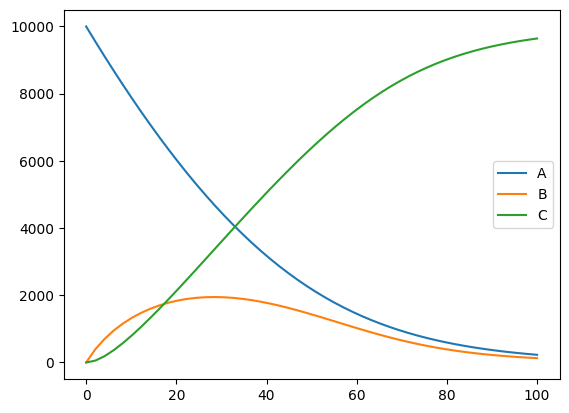

In [4]:
# run the model
kinetics_model.run_model()
kinetics_model.plot_substrate("A")
kinetics_model.plot_substrate("B")
kinetics_model.plot_substrate("C", plot=True)

## Define trainable model
The model will initially have perturbed parameters that will be optimized using the trajectory observed from Kinetics.

In [5]:
reaction_1 = reactions.UniReaction(
    name="A->B",
    enzyme="enz_1",
    substrates=["A"],
    products=["B"],
    kcat=34.0,
    kma=500.0,
)
reaction_2 = reactions.UniReaction(
    name="B->C",
    enzyme="enz_2",
    substrates=["B"],
    products=["C"],
    kcat=200.0,
    kma=8000.0,
)

model = models.Model()
model.add_reaction(reaction_1)
model.add_reaction(reaction_2)

In [6]:
model

Model(
  (reactions): ModuleDict(
    (A->B): UniReaction()
    (B->C): UniReaction()
  )
)

## Preprocess observed data

In [7]:
# number of batched trajectories to learn from
num_batches = 5
# might be a bit too excessive
num_training_steps = 500

In [8]:
# get the data from the ground truth model
kinetics_col_names = kinetics_model.run_model_species_names
kinetics_trajectory = kinetics_model.y
kinetics_tt = kinetics_model.time

In [9]:
# swap columns in 2d kinetics trajectory to match the differentiable model state alignment
state_mapping = model.get_state_mapping()
kinetics_index = torch.as_tensor(
    [state_mapping[metabolite] for metabolite in kinetics_col_names],
    dtype=torch.long,
)

target_trajectory = torch.as_tensor(kinetics_trajectory, dtype=torch.float32)
target_trajectory = target_trajectory.gather(
    dim=1, index=kinetics_index.expand(kinetics_trajectory.shape[0], -1)
)

In [10]:
# transform 2d trajectory (T, D) into time-leading batched one (T, B, D)
target_trajectory_batched = torch.stack(target_trajectory.chunk(num_batches), dim=1)
target_trajectory_batched.size()

torch.Size([10, 5, 5])

In [11]:
# split the integration timeline returned by Kinetics into batches
kinetics_tt_batched = np.asarray(np.split(kinetics_tt, num_batches))
kinetics_tt_batched.shape

(5, 10)

## Evaluate model before training

In [12]:
# jit trainable model
model = torch.jit.script(model)

In [13]:
# one element slice gives correct dimension
s0 = target_trajectory[0:1, :]
solution = torchdiffeq.odeint_adjoint(model, s0, torch.as_tensor(kinetics_tt))
solution = solution.squeeze(1)

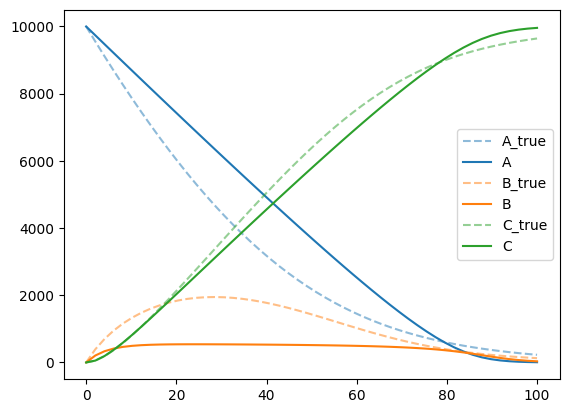

In [14]:
plotting.plot_simulated_vs_true(
    timeline=kinetics_tt,
    simulated_trajectory=solution.detach().numpy(),
    true_trajectory=target_trajectory.detach().numpy(),
    state_mapping=state_mapping,
)

In [20]:
# plot batched simulation
tt_batch = torch.as_tensor(kinetics_tt_batched[0])
s0_batch = target_trajectory_batched[0, :, :]
solution = torchdiffeq.odeint_adjoint(model, s0_batch, tt_batch)

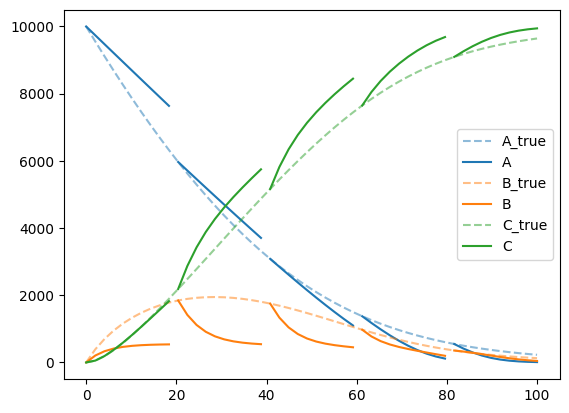

In [21]:
plotting.plot_batched_simulated_vs_true(
    batched_timeline=kinetics_tt_batched,
    batched_simulated_trajectory=solution.detach().numpy(),
    true_trajectory=target_trajectory.detach().numpy(),
    state_mapping=state_mapping,
)

## Restoring true parameters with backprop

In [22]:
# we are training on all data, so maybe huge learning rate is fine
optimizer = torch.optim.Adam(model.parameters(), lr=100)
loss_fn = torch.nn.MSELoss()

In [23]:
for step in tqdm.trange(num_training_steps):
    optimizer.zero_grad()

    solution = torchdiffeq.odeint_adjoint(model, s0_batch, tt_batch)
    loss = loss_fn(solution, target_trajectory_batched)
    loss.backward()

    print(f"step {step}, loss: {loss.detach().numpy()}")

    optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]

step 0, loss: 194411.90625
step 1, loss: 1188504.375
step 2, loss: 715200.125
step 3, loss: 1028063.0
step 4, loss: 724648.4375
step 5, loss: 151490.609375
step 6, loss: 264837.46875
step 7, loss: 582196.1875
step 8, loss: 705883.375
step 9, loss: 589376.0
step 10, loss: 352929.5625
step 11, loss: 184811.90625
step 12, loss: 222552.875
step 13, loss: 376279.4375
step 14, loss: 403879.9375
step 15, loss: 268197.5
step 16, loss: 129966.90625
step 17, loss: 89483.3984375
step 18, loss: 119427.0078125
step 19, loss: 152564.21875
step 20, loss: 152918.21875
step 21, loss: 124083.7578125
step 22, loss: 85417.953125
step 23, loss: 53286.01953125
step 24, loss: 45635.75390625
step 25, loss: 72618.2109375
step 26, loss: 106747.8828125
step 27, loss: 105472.328125
step 28, loss: 66005.5234375
step 29, loss: 25017.095703125
step 30, loss: 13069.3896484375
step 31, loss: 29360.662109375
step 32, loss: 52744.33984375
step 33, loss: 63276.30859375
step 34, loss: 54574.421875
step 35, loss: 34579.339

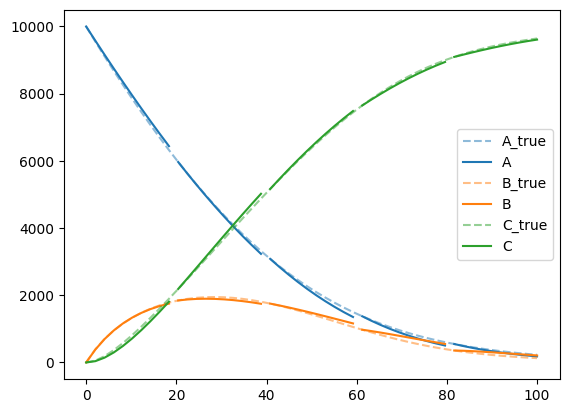

In [24]:
plotting.plot_batched_simulated_vs_true(
    batched_timeline=kinetics_tt_batched,
    batched_simulated_trajectory=solution.detach().numpy(),
    true_trajectory=target_trajectory.detach().numpy(),
    state_mapping=state_mapping,
)

In [25]:
dict(model.named_parameters())

{'reactions.A->B.kcat': Parameter containing:
 tensor(77.1152, requires_grad=True),
 'reactions.A->B.kma': Parameter containing:
 tensor(4780.0503, requires_grad=True),
 'reactions.B->C.kcat': Parameter containing:
 tensor(94.8563, requires_grad=True),
 'reactions.B->C.kma': Parameter containing:
 tensor(9556.9795, requires_grad=True)}